# Chapter 6: Decision Trees - Notebook Reproduksi Kode

Bab ini mengeksplorasi Decision Trees (Pohon Keputusan), algoritma ML serbaguna
untuk klasifikasi dan regresi.

Kita akan melihat:
- Melatih dan memvisualisasikan Pohon Keputusan.
- Membuat prediksi dan mengestimasi probabilitas kelas.
- Algoritma pelatihan CART.
- Impuritas Gini vs. Entropi.
- Hyperparameter regularisasi.
- Pohon Keputusan untuk tugas regresi.
- Instabilitas Pohon Keputusan.

--- Melatih DecisionTreeClassifier ---
DecisionTreeClassifier berhasil dilatih.
Pohon Keputusan diekspor ke: ./images/decision_trees/iris_tree.dot
Untuk melihat gambar, jalankan di terminal (setelah menginstal Graphviz):
dot -Tpng ./images/decision_trees/iris_tree.dot -o ./images/decision_trees/iris_tree.png

--- Membuat Prediksi dengan Pohon Keputusan ---
Prediksi kelas untuk [[5, 1.5]]: versicolor

--- Mengestimasi Probabilitas Kelas ---
Probabilitas kelas untuk [[5, 1.5]]:
  setosa: 0.0000
  versicolor: 0.9074
  virginica: 0.0926


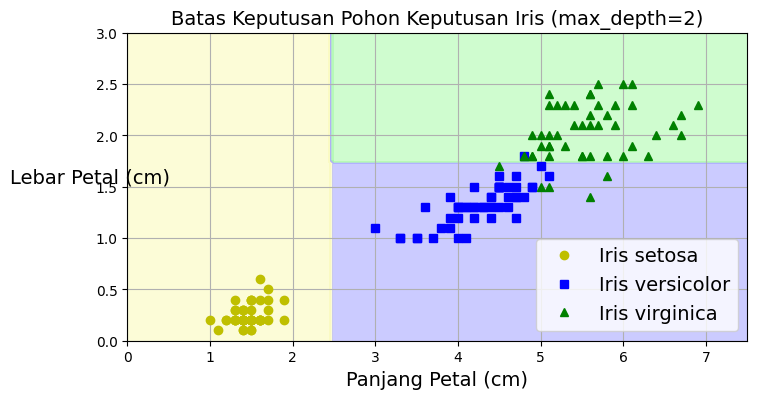

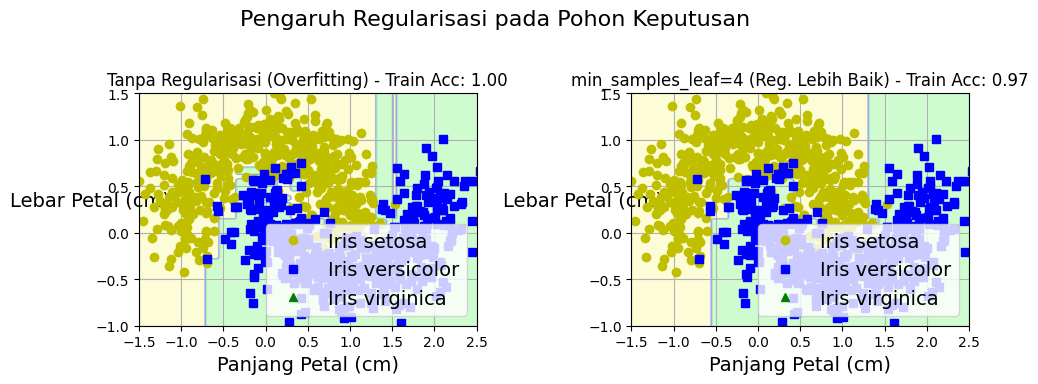


--- Melatih DecisionTreeRegressor (max_depth=2) ---
DecisionTreeRegressor max_depth=2 berhasil dilatih.
Pohon Regresi diekspor ke: ./images/decision_trees/tree_reg_md2.dot

--- Melatih DecisionTreeRegressor (max_depth=3) ---
DecisionTreeRegressor max_depth=3 berhasil dilatih.


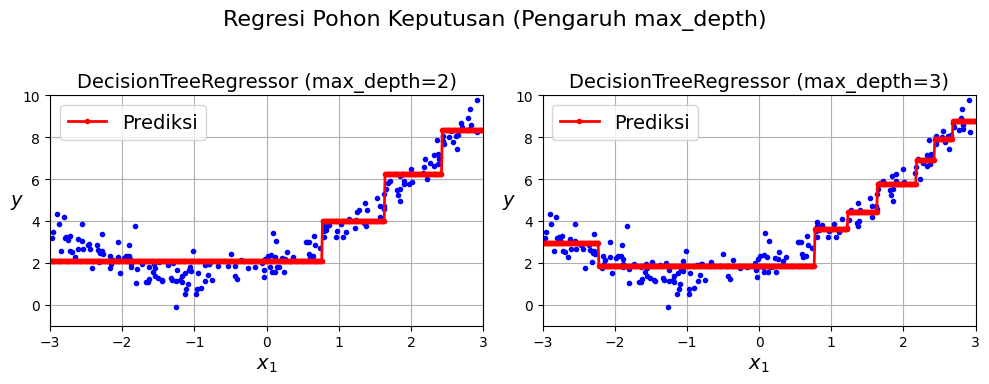


--- DecisionTreeRegressor (Tanpa Regularisasi - Overfitting) ---
RMSE pada data pelatihan: 0.00


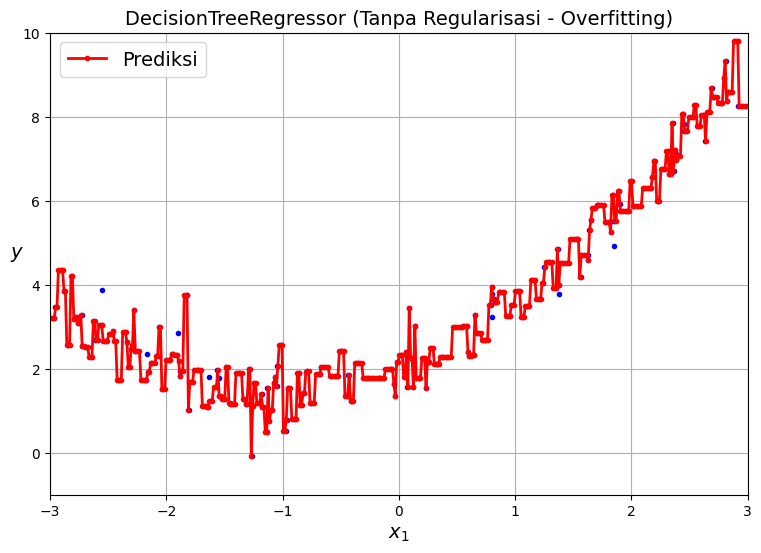


--- DecisionTreeRegressor (dengan min_samples_leaf=10) ---
RMSE pada data pelatihan: 0.45


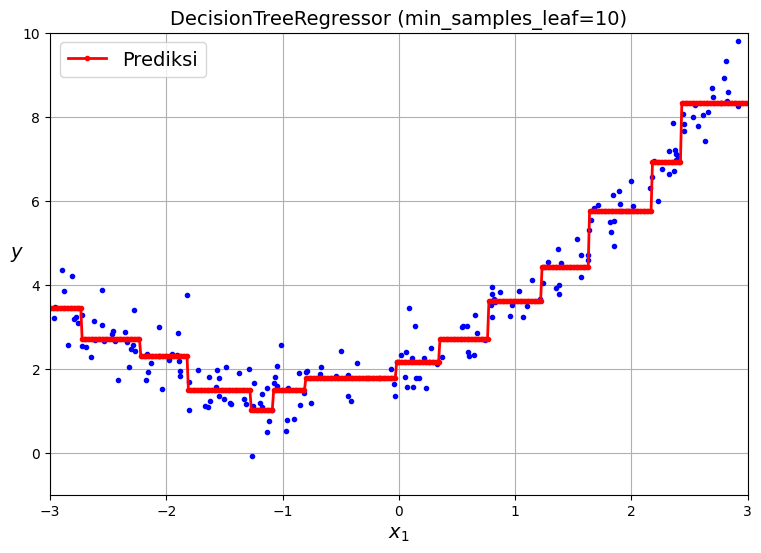


--- Selesai Reproduksi Kode Chapter 6 ---


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl # FIX: Menambahkan impor eksplisit untuk mpl
from sklearn.datasets import load_iris, make_moons
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.base import clone # Digunakan dalam latihan untuk ensemble
import os

# Untuk menghasilkan gambar .dot (untuk visualisasi pohon)
# Pastikan Graphviz terinstal dan ada di PATH sistem Anda.
# Jika tidak, Anda bisa instal dengan:
# conda install python-graphviz
# atau pip install graphviz
# dan instal Graphviz sendiri dari: https://graphviz.org/download/
# Lalu jalankan dari terminal: dot -Tpng iris_tree.dot -o iris_tree.png

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def image_path(filename):
    return os.path.join(IMAGES_PATH, filename)

# --- 1. Melatih dan Memvisualisasikan Pohon Keputusan ---

# Memuat dataset Iris
iris = load_iris()
X = iris.data[:, 2:] # Petal length dan petal width
y = iris.target

# Melatih DecisionTreeClassifier
# max_depth=2 untuk pohon yang sederhana agar mudah divisualisasikan
print("--- Melatih DecisionTreeClassifier ---")
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)
print("DecisionTreeClassifier berhasil dilatih.")

# Memvisualisasikan Pohon Keputusan
dot_file_path = image_path("iris_tree.dot")
export_graphviz(
    tree_clf,
    out_file=dot_file_path,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)
print(f"Pohon Keputusan diekspor ke: {dot_file_path}")
print("Untuk melihat gambar, jalankan di terminal (setelah menginstal Graphviz):")
print(f"dot -Tpng {dot_file_path} -o {image_path('iris_tree.png')}")

# --- 2. Membuat Prediksi ---
# Prediksi untuk contoh baru (petal length=5cm, petal width=1.5cm)
# Mengikuti jalur di pohon (mirip Gambar 6-1 di buku)

print("\n--- Membuat Prediksi dengan Pohon Keputusan ---")
new_instance = [[5, 1.5]]
predicted_class = tree_clf.predict(new_instance)
print(f"Prediksi kelas untuk {new_instance}: {iris.target_names[predicted_class][0]}")

# Mengestimasi Probabilitas Kelas
print("\n--- Mengestimasi Probabilitas Kelas ---")
predicted_proba = tree_clf.predict_proba(new_instance)
print(f"Probabilitas kelas untuk {new_instance}:")
for i, proba in enumerate(predicted_proba[0]):
    print(f"  {iris.target_names[i]}: {proba:.4f}")

# Memvisualisasikan Batas Keputusan Pohon
def plot_decision_boundary(clf, X, y, plot_training_set=True, axes=[0, 7.5, 0, 3]):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.5)
    if not plot_training_set:
        plt.contour(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.8)
    if plot_training_set:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Panjang Petal (cm)", fontsize=14)
    plt.ylabel("Lebar Petal (cm)", fontsize=14, rotation=0)
    plt.axis(axes)
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.title("Batas Keputusan Pohon Keputusan Iris (max_depth=2)", fontsize=14)
plt.show()

# --- 3. Hyperparameter Regularisasi ---
# Contoh pengaruh regularisasi pada dataset moons (non-linier)

X_moons, y_moons = make_moons(n_samples=1000, noise=0.25, random_state=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, random_state=42)

# Pohon tanpa regularisasi (cenderung overfitting)
tree_clf_unreg = DecisionTreeClassifier(random_state=42)
tree_clf_unreg.fit(X_train_moons, y_train_moons)

# Pohon dengan regularisasi (min_samples_leaf=4)
tree_clf_reg = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
tree_clf_reg.fit(X_train_moons, y_train_moons)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_unreg, X_moons, y_moons, axes=[-1.5, 2.5, -1, 1.5])
plt.title(f"Tanpa Regularisasi (Overfitting) - Train Acc: {accuracy_score(y_train_moons, tree_clf_unreg.predict(X_train_moons)):.2f}", fontsize=12)

plt.subplot(122)
plot_decision_boundary(tree_clf_reg, X_moons, y_moons, axes=[-1.5, 2.5, -1, 1.5])
plt.title(f"min_samples_leaf=4 (Reg. Lebih Baik) - Train Acc: {accuracy_score(y_train_moons, tree_clf_reg.predict(X_train_moons)):.2f}", fontsize=12)

plt.suptitle("Pengaruh Regularisasi pada Pohon Keputusan", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 4. Pohon Keputusan untuk Regresi ---

# Generasi data kuadratik dengan noise
np.random.seed(42)
X_reg = np.random.rand(200, 1) * 6 - 3 # Dari -3 sampai 3
y_reg = 0.5 * X_reg**2 + X_reg + 2 + np.random.randn(200, 1) * 0.5 # y = 0.5x^2 + x + 2 + noise

# Melatih DecisionTreeRegressor
# max_depth=2
print("\n--- Melatih DecisionTreeRegressor (max_depth=2) ---")
tree_reg_md2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_md2.fit(X_reg, y_reg)
print("DecisionTreeRegressor max_depth=2 berhasil dilatih.")

# Visualisasi pohon regresi (dot export)
dot_file_path_reg_md2 = image_path("tree_reg_md2.dot")
export_graphviz(
    tree_reg_md2,
    out_file=dot_file_path_reg_md2,
    feature_names=["x1"],
    rounded=True,
    filled=True
)
print(f"Pohon Regresi diekspor ke: {dot_file_path_reg_md2}")

# Plot hasil regresi
def plot_regression_tree(tree_reg, X, y, axes=[-3, 3, -1, 10]):
    x1s = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1s)
    plt.plot(X, y, "b.")
    plt.plot(x1s, y_pred, "r.-", linewidth=2, label="Prediksi")
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$y$", fontsize=14, rotation=0)
    plt.axis(axes)
    plt.grid(True)
    plt.legend(loc="upper left", fontsize=14)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_regression_tree(tree_reg_md2, X_reg, y_reg)
plt.title("DecisionTreeRegressor (max_depth=2)", fontsize=14)

# Melatih DecisionTreeRegressor dengan max_depth=3
tree_reg_md3 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg_md3.fit(X_reg, y_reg)
print("\n--- Melatih DecisionTreeRegressor (max_depth=3) ---")
print("DecisionTreeRegressor max_depth=3 berhasil dilatih.")

plt.subplot(122)
plot_regression_tree(tree_reg_md3, X_reg, y_reg)
plt.title("DecisionTreeRegressor (max_depth=3)", fontsize=14)
plt.suptitle("Regresi Pohon Keputusan (Pengaruh max_depth)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Contoh Overfitting pada Regresi Pohon Keputusan (tanpa regularisasi)
tree_reg_unreg_full = DecisionTreeRegressor(random_state=42) # Tanpa batasan kedalaman
tree_reg_unreg_full.fit(X_reg, y_reg)
print("\n--- DecisionTreeRegressor (Tanpa Regularisasi - Overfitting) ---")
print(f"RMSE pada data pelatihan: {np.sqrt(mean_squared_error(y_reg, tree_reg_unreg_full.predict(X_reg))):.2f}")

plt.figure(figsize=(9, 6))
plot_regression_tree(tree_reg_unreg_full, X_reg, y_reg, axes=[-3, 3, -1, 10])
plt.title("DecisionTreeRegressor (Tanpa Regularisasi - Overfitting)", fontsize=14)
plt.show()

# Contoh Regularisasi pada Regresi Pohon Keputusan (min_samples_leaf)
tree_reg_reg_leaf = DecisionTreeRegressor(min_samples_leaf=10, random_state=42)
tree_reg_reg_leaf.fit(X_reg, y_reg)
print("\n--- DecisionTreeRegressor (dengan min_samples_leaf=10) ---")
print(f"RMSE pada data pelatihan: {np.sqrt(mean_squared_error(y_reg, tree_reg_reg_leaf.predict(X_reg))):.2f}")

plt.figure(figsize=(9, 6))
plot_regression_tree(tree_reg_reg_leaf, X_reg, y_reg, axes=[-3, 3, -1, 10])
plt.title("DecisionTreeRegressor (min_samples_leaf=10)", fontsize=14)
plt.show()

print("\n--- Selesai Reproduksi Kode Chapter 6 ---")
